#### Standard 3D RB Convolutional Autoencoder

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import math

import h5py
import os
import sys
sys.path.append('..')

2024-10-27 17:58:51.610230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 17:58:51.642502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 17:58:52.115446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# do not take all of the GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Data

In [3]:
RB_CHANNELS = 4

BATCH_SIZE = 32

SIMULATION_NAME = '48_48_32_1500_0.71_0.01_0.3_1000.2'
HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [4]:
sim_file = os.path.join('..', 'data', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

class generator:
    def __init__(self, filename, dataset):
        self.filename = filename
        self.dataset = dataset

    def __call__(self):
        while True:
            with h5py.File(self.filename, 'r') as hf:
                for snap in hf[self.dataset]:
                    yield snap, snap

spec = tf.TensorSpec(shape=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS), dtype=tf.float64)

train_dataset = tf.data.Dataset.from_generator(
     generator(sim_file, 'train'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)
test_dataset = tf.data.Dataset.from_generator(
     generator(sim_file, 'test'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)

2024-10-27 17:58:52.982729: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-27 17:58:52.983982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 71166 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


## Model Definition

In [16]:
from models import cnn_model, gcnn_model
model = cnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE)
# model = gcnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE)

# output shape: batch_size, width, depth, height, channels
# model.summary()

## Training

In [9]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError, 
    optimizer=keras.optimizers.Adam(learning_rate=0.00001)
)

hist = model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=True, 
                 steps_per_epoch=math.ceil(N_train/BATCH_SIZE), validation_steps=math.ceil(N_test/BATCH_SIZE))

Epoch 1/100


84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - loss: 0.1182 - val_loss: 0.0638
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 0.1188 - val_loss: 0.0636
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 0.1201 - val_loss: 0.0626
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 0.1212 - val_loss: 0.0627
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - loss: 0.1178 - val_loss: 0.0630
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.1195 - val_loss: 0.0640
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 0.1204 - val_loss: 0.0630
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 0.1213 - val_loss: 0.0650
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - loss: 0.1236 - val_loss: 0.0641
Epoch 10/100
 4/84 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 0.0987

KeyboardInterrupt: 

## Evaluation

In [10]:
snapshots = list(test_dataset.take(1))[0][0]
decoded = model.predict(snapshots)

2024-10-27 18:07:53.374817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


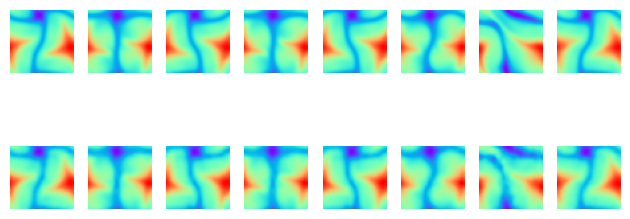

In [11]:
from matplotlib import pyplot as plt

snapshots_unstandardized = snapshots*standardization_std+standardization_mean
decoded_unstandardized = decoded*standardization_std+standardization_mean

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


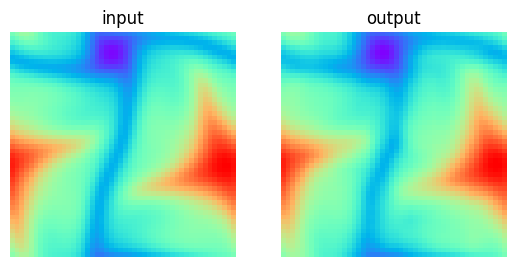

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
pred_batch_size = 1024
def predict_batch(sim_data, i, size=pred_batch_size):
    orig = np.transpose(sim_data[:, :, :, :, i*size:(i+1)*size], [4,2,1,0,3])
    orig_standardized = np.divide((orig - standardization_mean), standardization_std, 
                                out=np.zeros_like(orig), where=standardization_std!=0)
    pred_standardized = model.predict(orig_standardized)
    pred_unstandardized = pred_standardized*standardization_std + standardization_mean
    return orig, pred_unstandardized

sim_file = h5py.File(
    os.path.join('..', 'simulation', '3d', 'data', SIMULATION_NAME, 'sim.h5'), 
    'r')
sim_data = sim_file['data']

batch_orig, batch_pred = predict_batch(sim_data, 0)
current_batch_nr = 0


fig = plt.figure()
ax = plt.subplot(1,2,1)
orig_im = plt.imshow(batch_orig[0, :, :, 16, 0], cmap='rainbow')
plt.axis('off')
ax.set_title('input')

ax = plt.subplot(1,2,2)
pred_im = plt.imshow(batch_pred[0, :, :, 16, 0], cmap='rainbow')
plt.axis('off')
ax.set_title('output')

def updatefig(frame):
    global batch_orig, batch_pred, current_batch_nr
    batch_nr, in_batch_frame = frame//pred_batch_size, frame%pred_batch_size
    if batch_nr > current_batch_nr:
        print(f'{batch_nr}/{sim_data.shape[-1]//pred_batch_size}')
        batch_orig, batch_pred = predict_batch(sim_data, batch_nr)
        current_batch_nr = batch_nr
    
    orig_data = batch_orig[in_batch_frame, :, :, 16, 0]
    pred_data = batch_pred[in_batch_frame, :, :, 16, 0]
    
    vmin = min(np.min(orig_data), np.min(pred_data))
    vmax = max(np.max(orig_data), np.max(pred_data))
    
    orig_im.set_array(orig_data)
    orig_im.set_clim(vmin=vmin, vmax=vmax)
    pred_im.set_array(pred_data)
    pred_im.set_clim(vmin=vmin, vmax=vmax)
    return orig_im, pred_im

ani = animation.FuncAnimation(fig, updatefig, frames=sim_data.shape[-1], interval=30, blit=True)
ani.save('video.mp4')

sim_file.close()